In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cnoidal
import serre
import muscl2

# Validation of the split scheme for the Serre equations using a 4th order scheme and the cnoidal solution

## Properties of the cnoidal solution

In [3]:
a0 = 0.3
a1 = 0.1
k = 0.99
g = 9.81
t = 0.0

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

print 'Wavelength = %.3f'%lam
print 'Reference depth = %.3f'%h0

Wavelength = 5.138
Reference depth = 0.327


## Discretization of the domain 
$x\in[-L,L]$, with $L=2\lambda$ and 100 points

In [4]:
L = 2*lam
xmin = -L
xmax = L
nx = 100
dx1 = (xmax-xmin)/(nx)
x,dx = serre.discretizeSpace(xmin-2.*dx1,xmax+2.*dx1,nx+4)

## Initial condition

In [5]:
h,u = cnoidal.analyticalSolution(x[2:-2],t,k,a0,a1)
h = serre.extend2GhostCells(h,2)
u = serre.extend2GhostCells(u,2)
h,u = serre.periodicDomainTwoGC(h,u,None,dx,0)

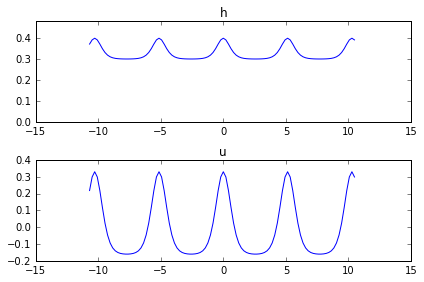

In [6]:
plt.figure()
plt.subplot(211)
plt.plot(x,h)
plt.ylim(0.,h.max()*1.2)
plt.title('h')
plt.subplot(212)
plt.plot(x,u)
plt.title('u')
plt.tight_layout()

## Simulation using the 2nd order FV shallow water scheme only

In [7]:
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,10.,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2TwoGC,None,None,dx,
                                     nx,vardt = False, dt = 0.05, splitSteps=3,
                                     order=2, periodic=True, fvsolver = muscl2.fluxes2, 
                                     fdsolver = serre.EFDSolverFM, ghostcells=2)

CFL = 5.760540


## Simulation using the 2x4 scheme (2nd order FV + 4th order FD)

In [8]:
u2 = np.copy(u)
h2 = np.copy(h)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,10.,serre.periodicDomainTwoGC,None,dx,nx,vardt = False, dt = 0.05,
                              fvsolver=muscl2.fluxes2, ghostcells=2)

CFL = 5.760540



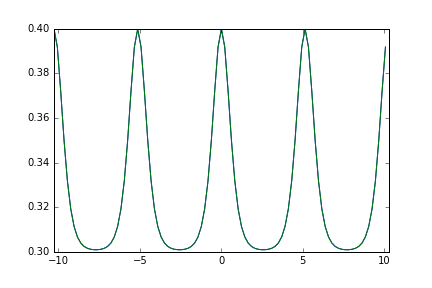
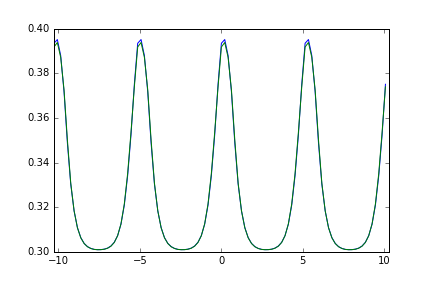
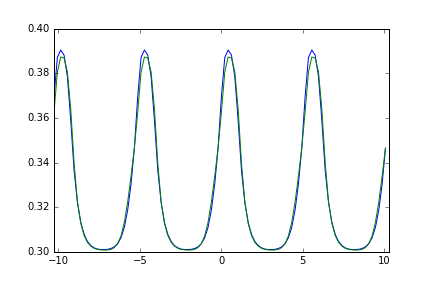
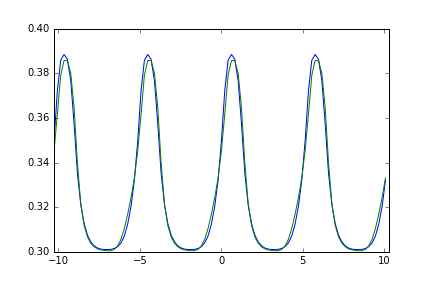
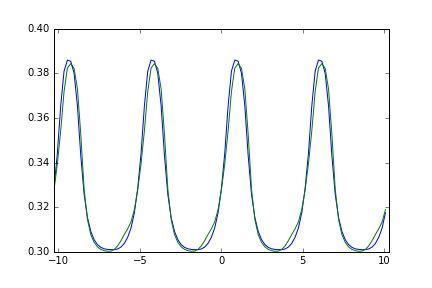
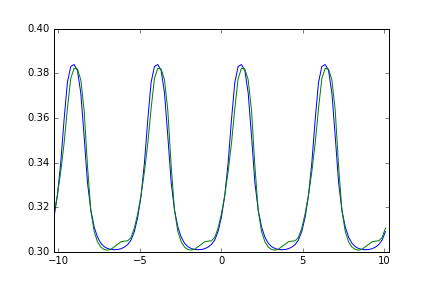
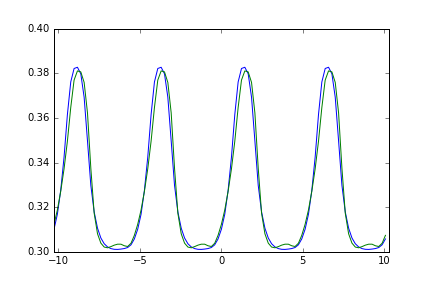
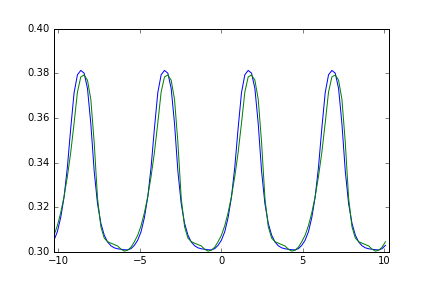
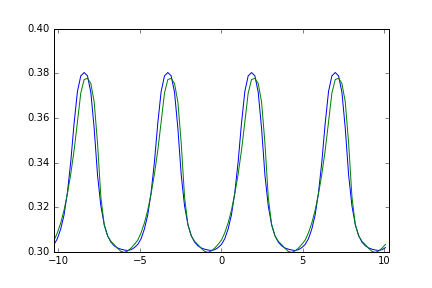
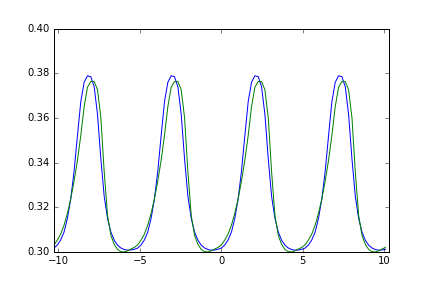
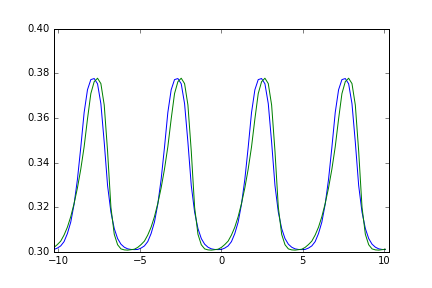
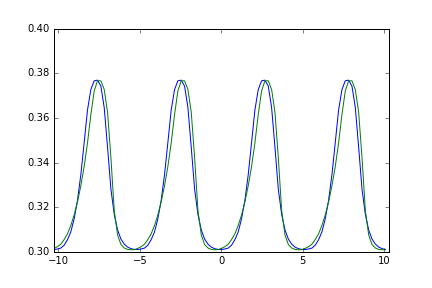
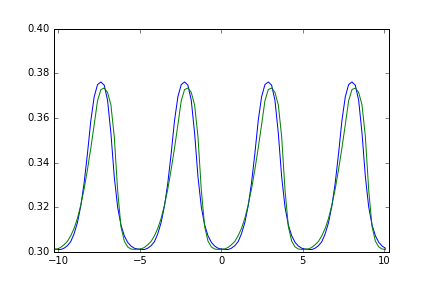
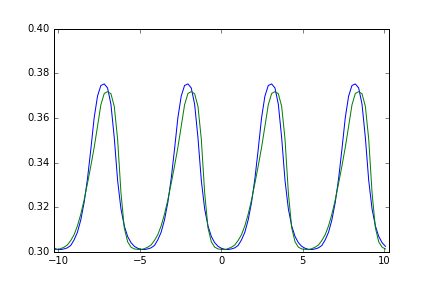
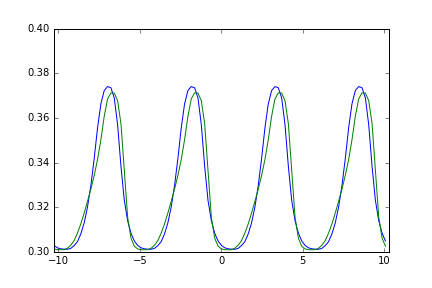
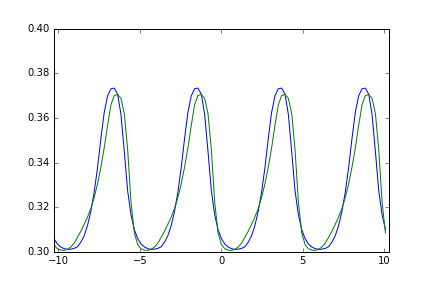
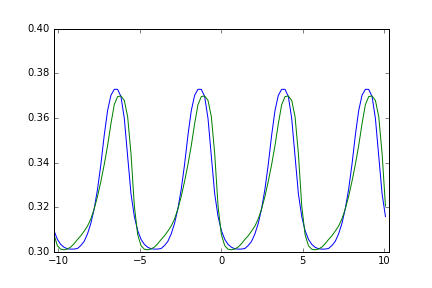
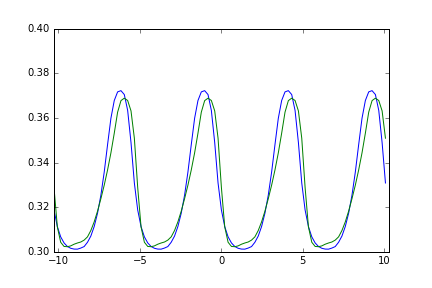
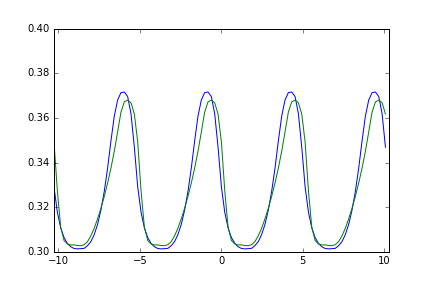
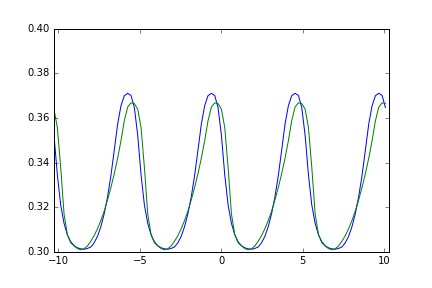
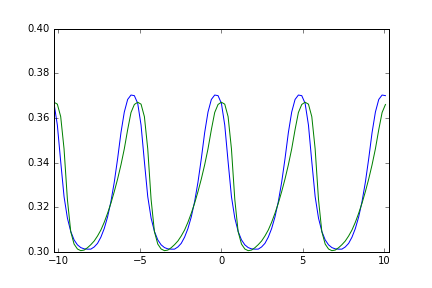
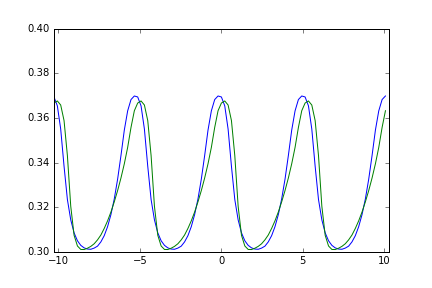
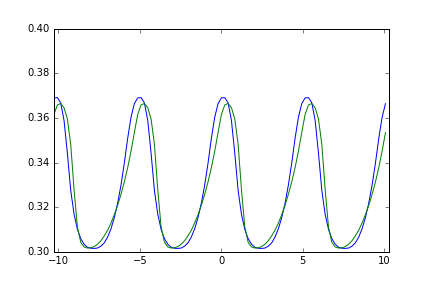
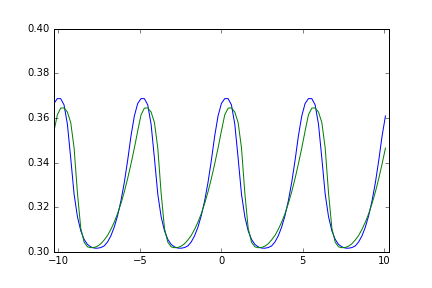
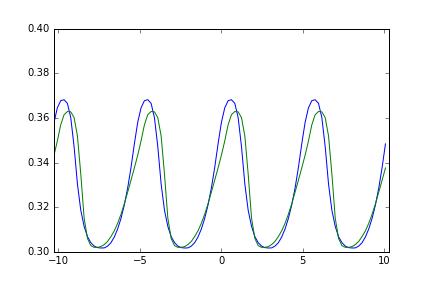
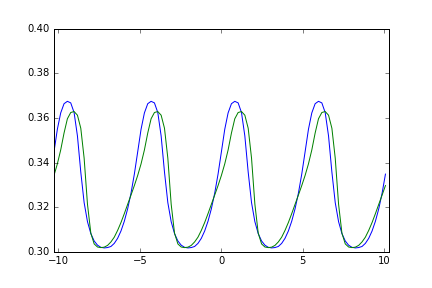
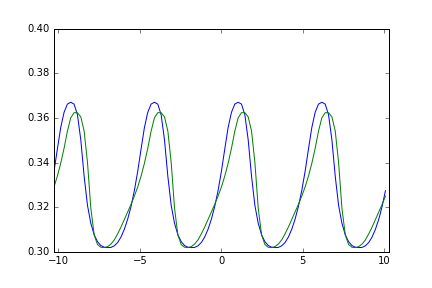
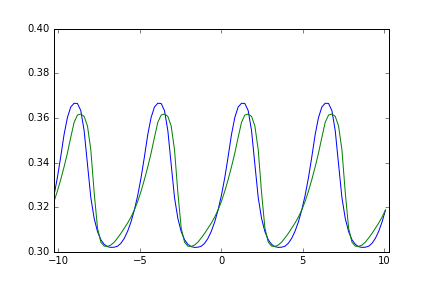
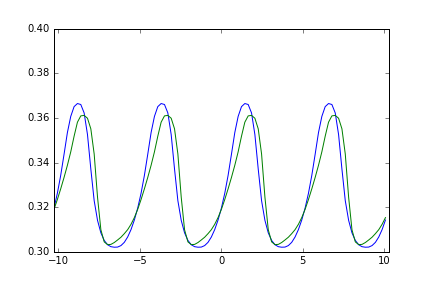
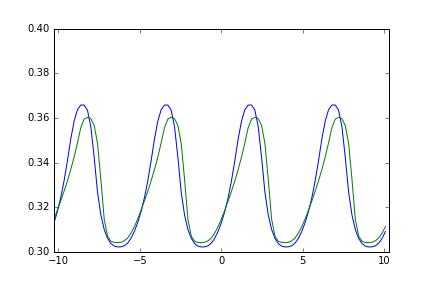
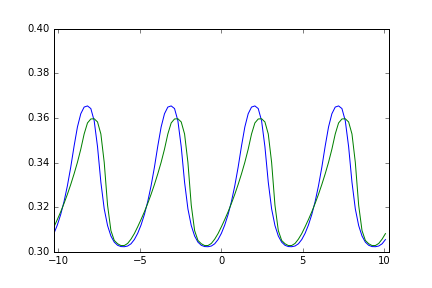
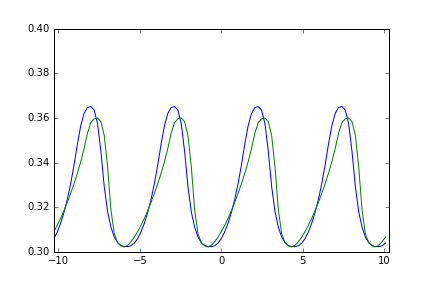
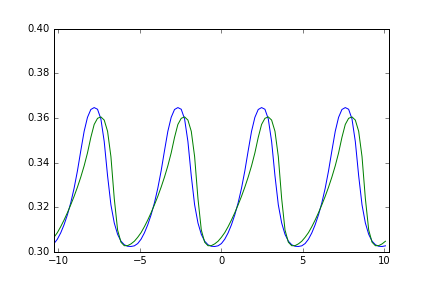
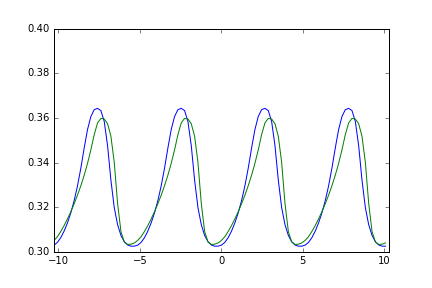
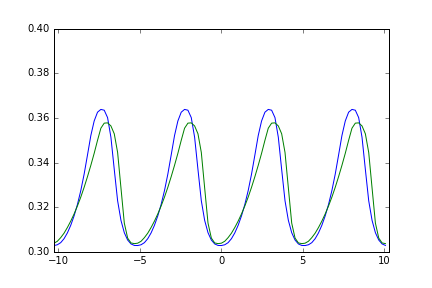
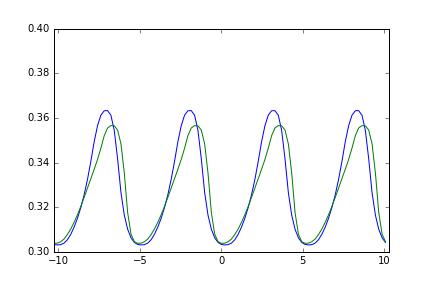
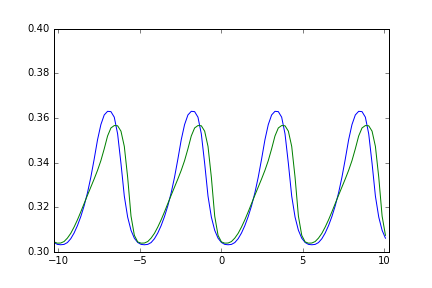
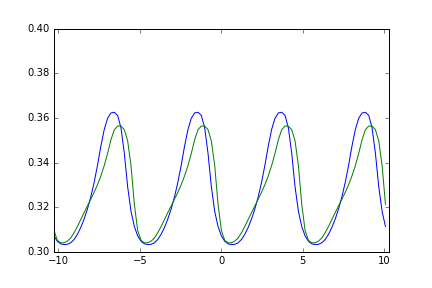
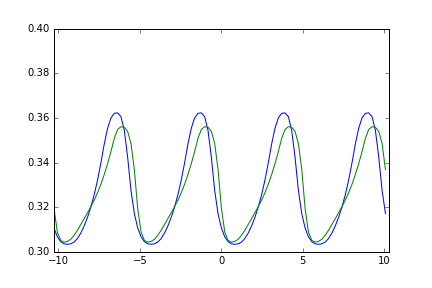
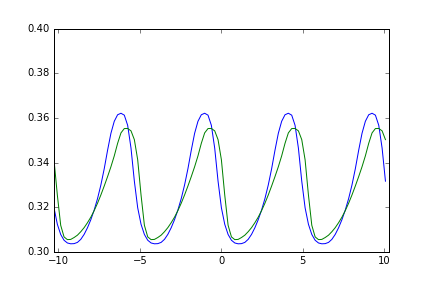

In [9]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0.3,0.4))
lineSerre, = ax.plot([], [])
lineSw, = ax.plot([], [])

def animate(i):
    i = min(hall1.shape[0],i*hall1.shape[0]/40)
    lineSerre.set_data(x[2:-2],hall1[2:-2,i])
    lineSw.set_data(x[2:-2],hall2[2:-2,i])

animation.FuncAnimation(fig, animate, frames=40, interval=200)

# Adding the fourth order FVscheme to the splitSerre routine

As explained in the notebook [nswe_muscl4_forSerre.ipynb](nswe_muscl4_forSerre.ipynb) the function that should work for interface fluxes and given as the "fvsolver" argument in the splitSerre function is

In [10]:
import nswe_wbmuscl4 as wb4
def fluxes_periodic(h,hu,n):
    nx = h.shape[0]-4
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)

    h0[3:-3] = h[2:-2]
    u0[3:-3] = hu[2:-2] #hu
    u0 = np.where(h0>1e-10,u0/h0,h0)#hu/h
    
    #periodic bcs
    h0[:3] = h0[-6:-3]
    h0[-3:] = h0[3:6]
    u0[:3] = u0[-6:-3]
    u0[-3:] = u0[3:6]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp

Although I had to modify line 3 (now it uses h.shape[0] instead of h.shape[1])
```python
    nx = h.shape[0]-4
```

## Simulation using the 4x4 scheme (4th order FV + 4th order FD)
The exact same scheme as in Bonneton et al. 2011, except for the slope limiters (not used)

In [11]:
u2 = np.copy(u)
h2 = np.copy(h)

hall3,uall3,tall3 = serre.splitSerre(x,h,u,0,10.,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2TwoGC,None,None,dx,
                                     nx,vardt = False, dt = 0.05, splitSteps=3,
                                     order=2, periodic=True, fvsolver = fluxes_periodic, 
                                     fdsolver = serre.EFDSolverFM, ghostcells=2)

CFL = 5.760540


/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


## Explicit solution

In [12]:
hallexact = np.copy(hall1)
uallexact = np.copy(uall1)
for i in range (tall1.size):
    hallexact[:,i],uallexact[:,i] = cnoidal.analyticalSolution(x,tall1[i],k,a0,a1)

# Comparison of with the explicit solution


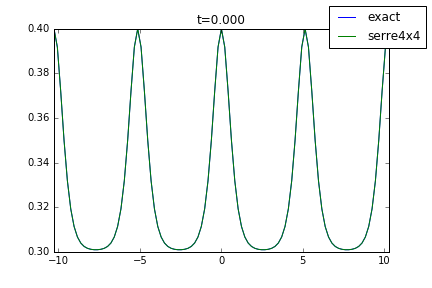
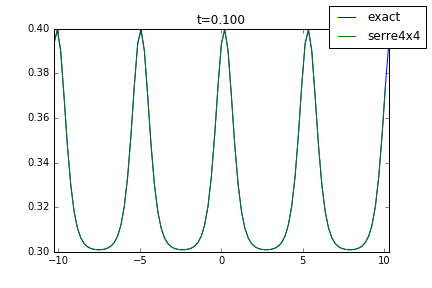
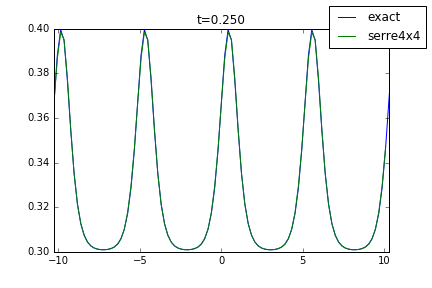
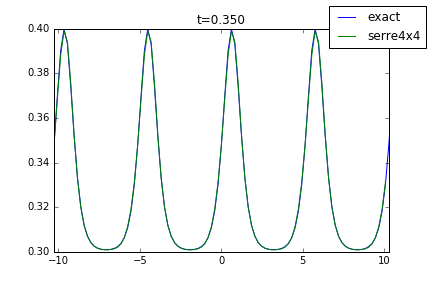
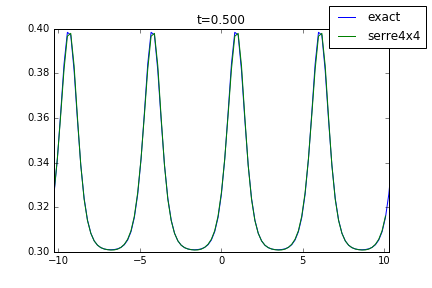
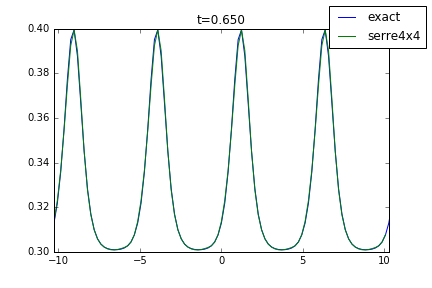
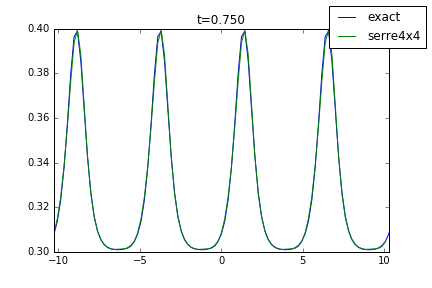
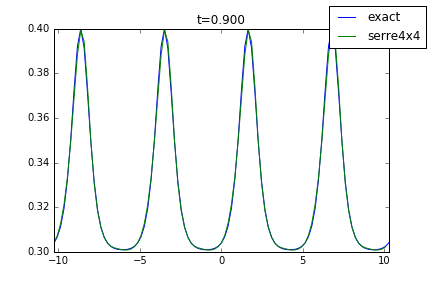
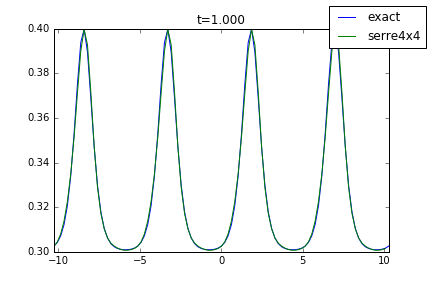
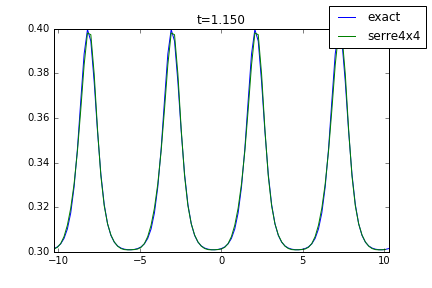
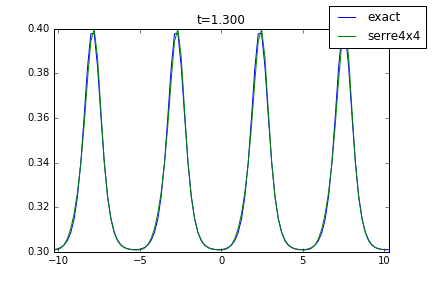
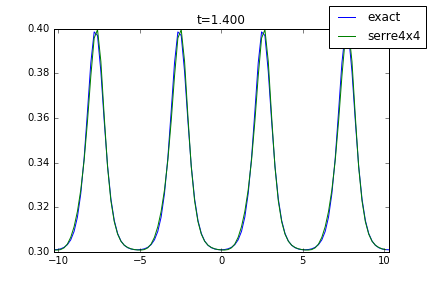
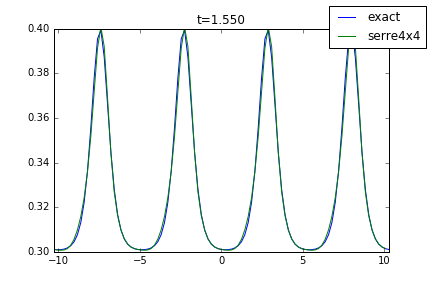
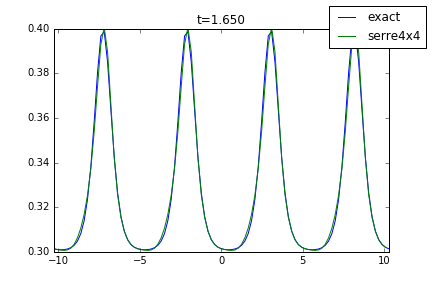
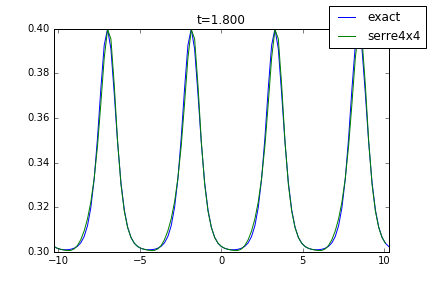
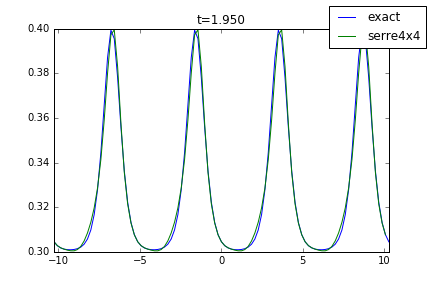
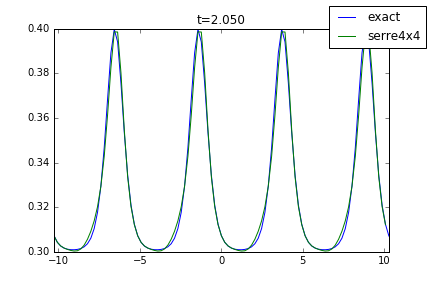
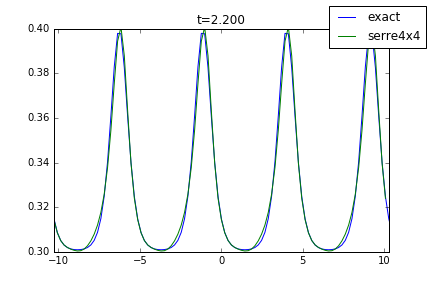
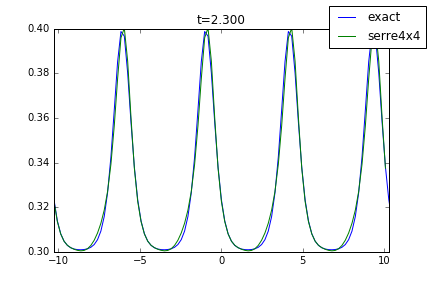
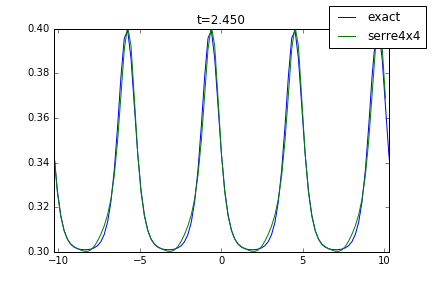
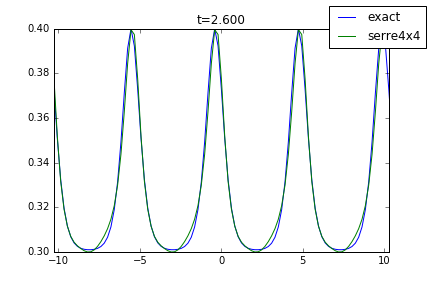
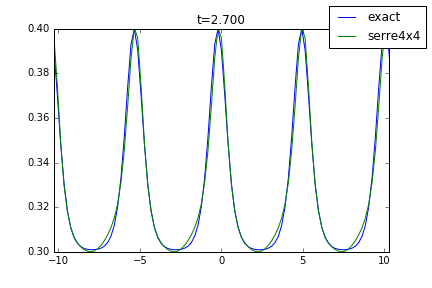
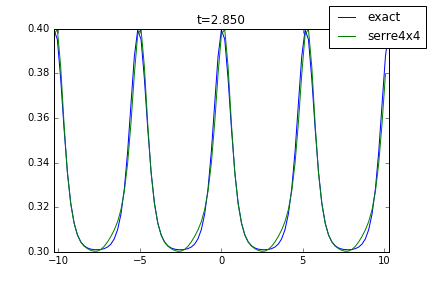
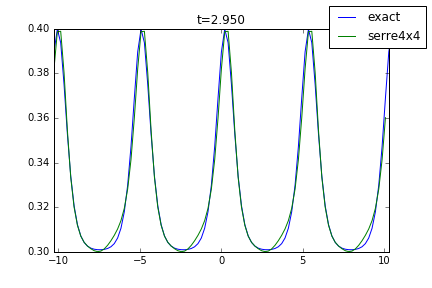
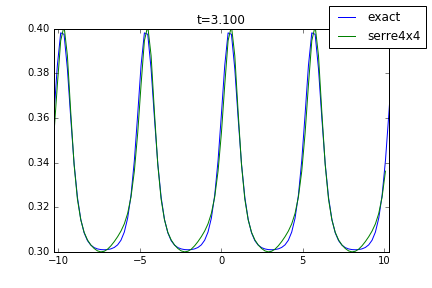
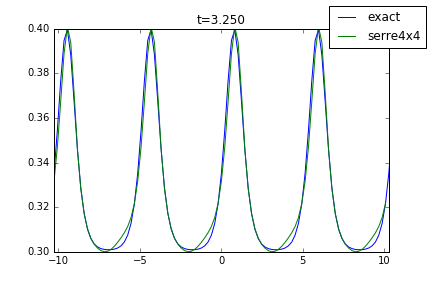
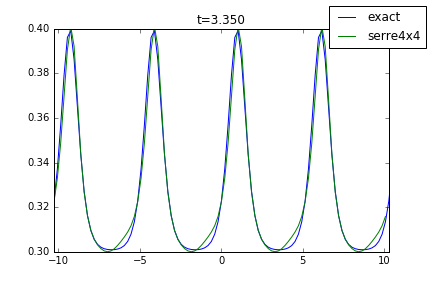
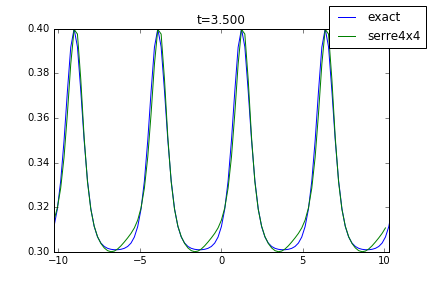
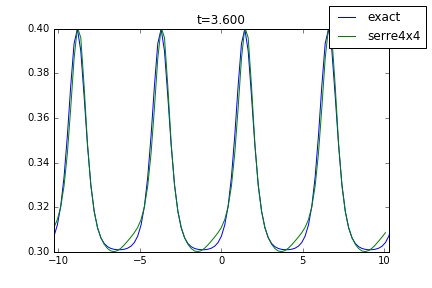
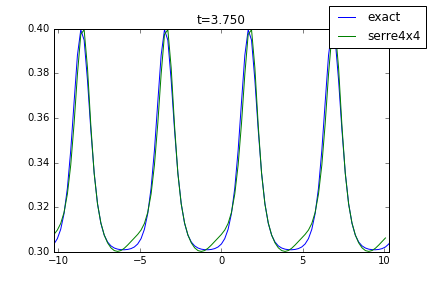
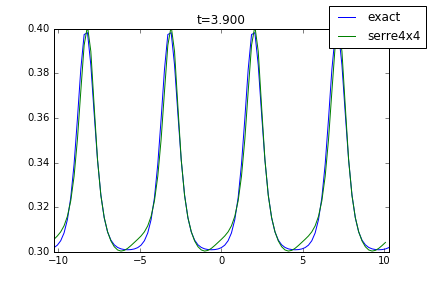
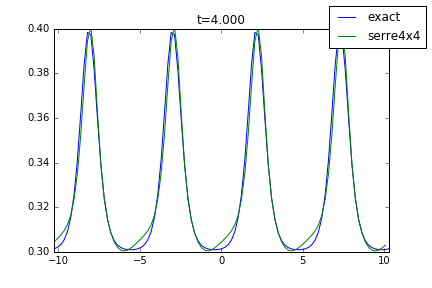
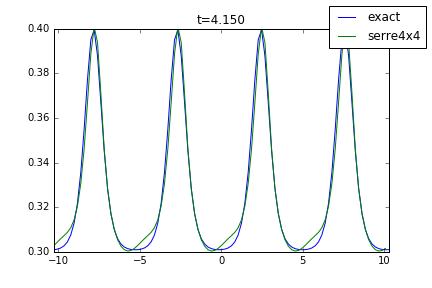
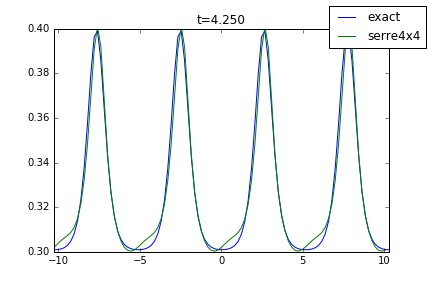
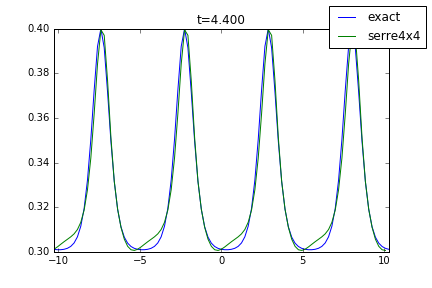
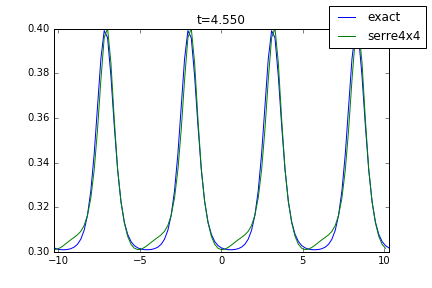
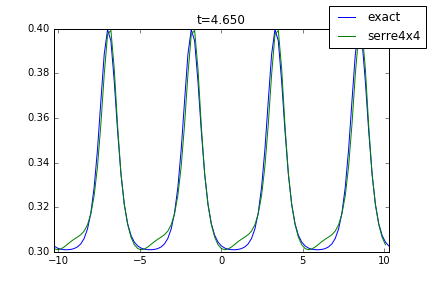
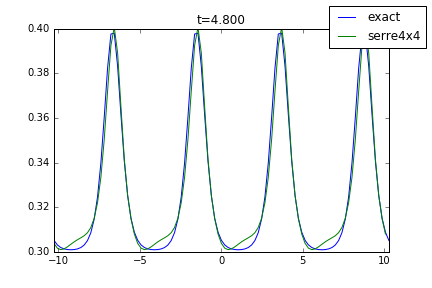
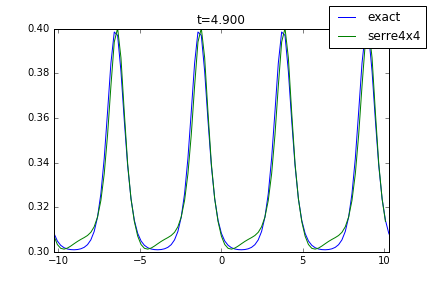
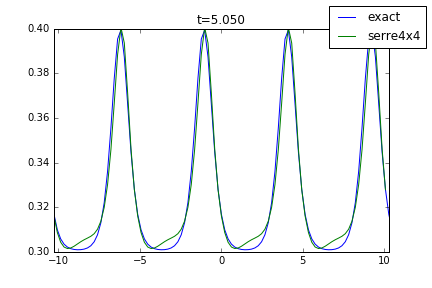

In [13]:
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0.3,0.4))

lineExact, = ax.plot(x, hallexact[:,0])
# lineSw, = ax.plot(x[2:-2],hall1[2:-2,0])
# lineSerre2, = ax.plot(x[2:-2],hall2[2:-2,0])
lineSerre4, = ax.plot(x[2:-2],hall3[2:-2,0])


ttl = ax.set_title('t=')
# fig.legend((lineExact,lineSw,lineSerre2,lineSerre4),
#            ('exact','nswe2','serre2x4','serre4x4'))
fig.legend((lineExact,lineSerre4),
           ('exact','serre4x4'))


def animate(i):
    i = min(hall1.shape[0],i*hall1.shape[0]/40)
    ttl.set_text('t=%.3f'%tall1[i])
    
    lineExact.set_data(x, hallexact[:,i])
#     lineSw.set_data(x[2:-2],hall2[2:-2,i])
#     lineSerre2.set_data(x[2:-2],hall1[2:-2,i])    
    lineSerre4.set_data(x[2:-2],hall3[2:-2,i])
    

animation.FuncAnimation(fig, animate, frames=40, interval=200)


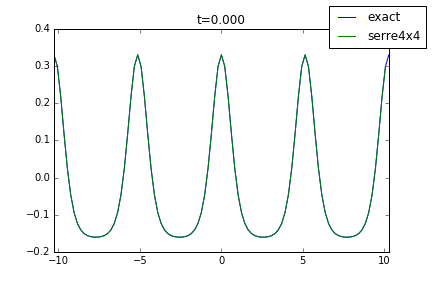
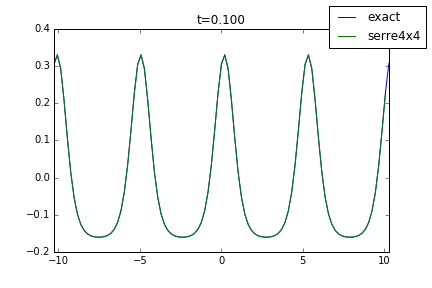
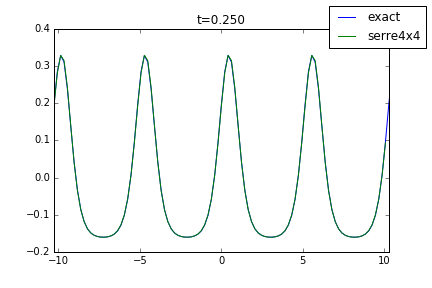
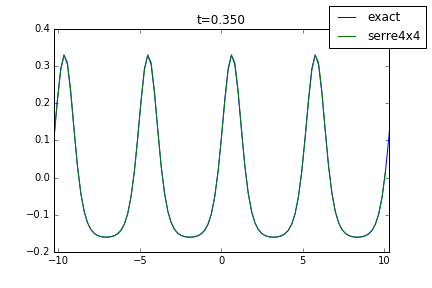
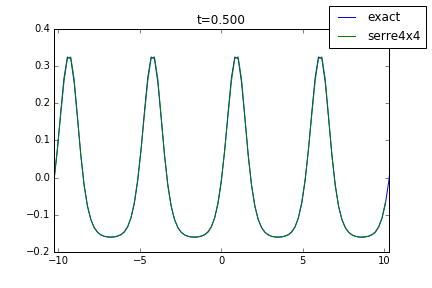
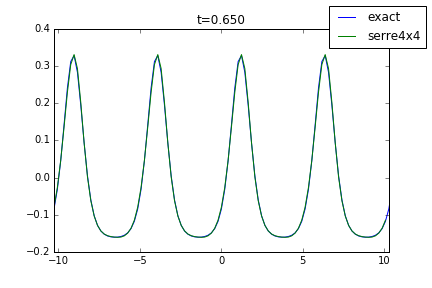
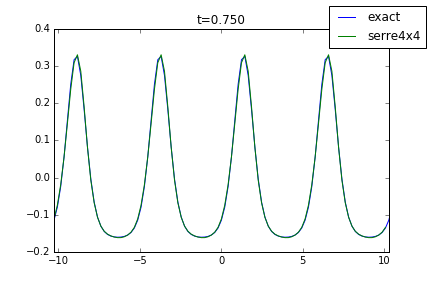
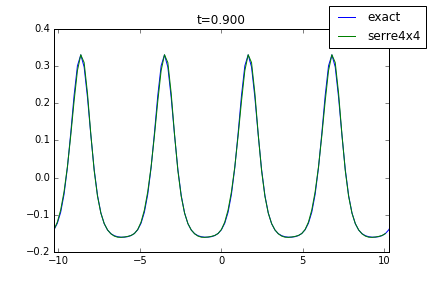
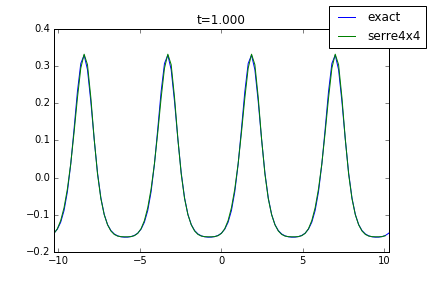
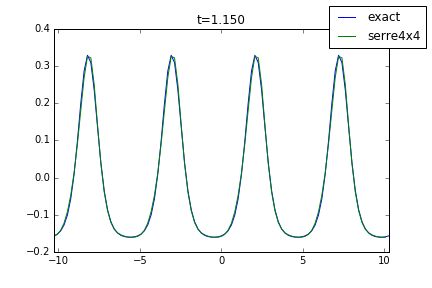
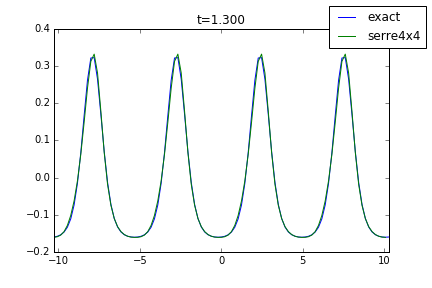
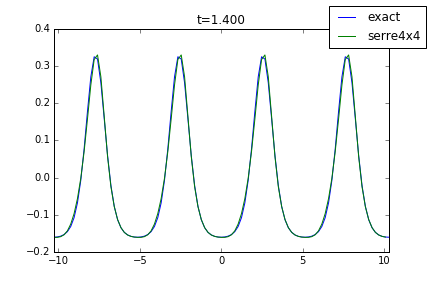
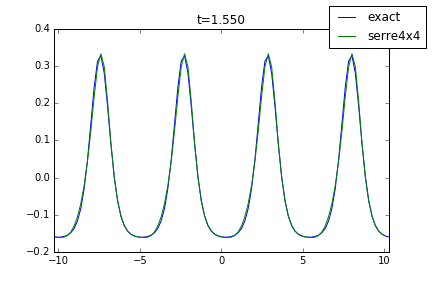
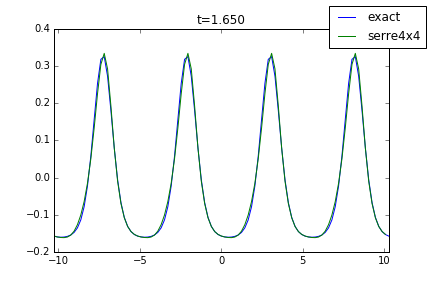
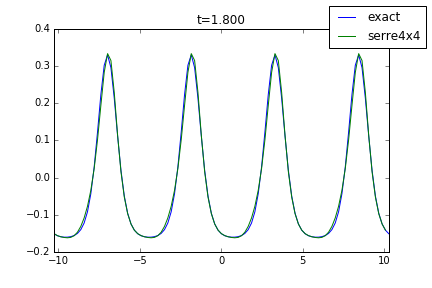
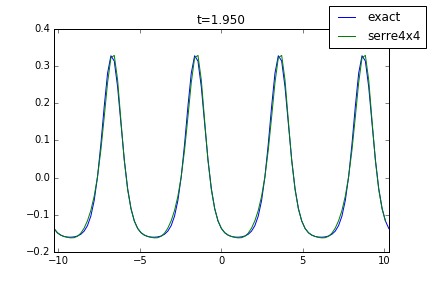
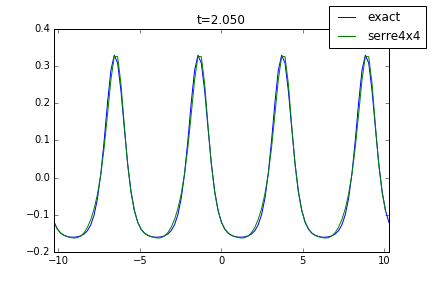
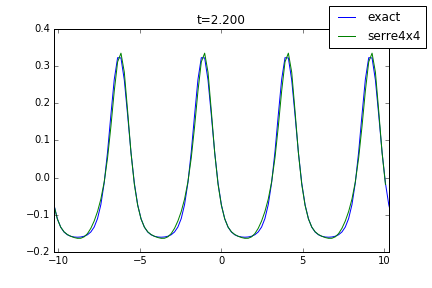
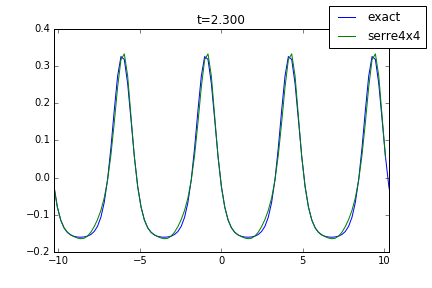
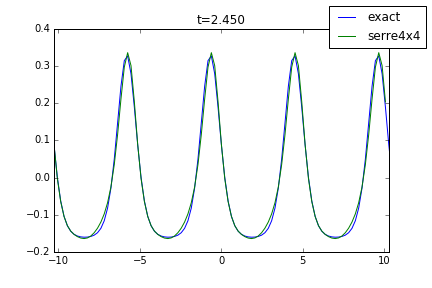
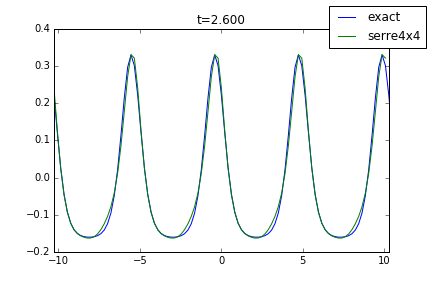
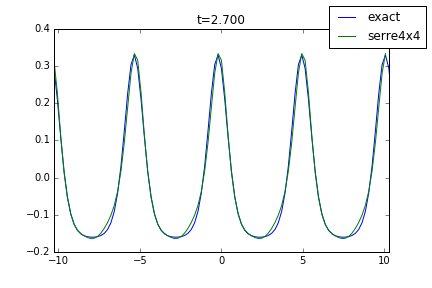
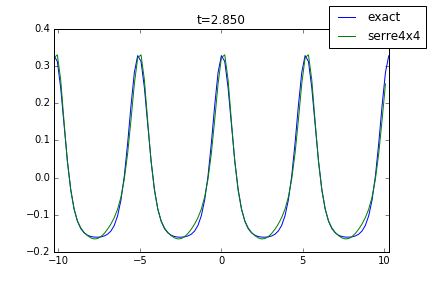
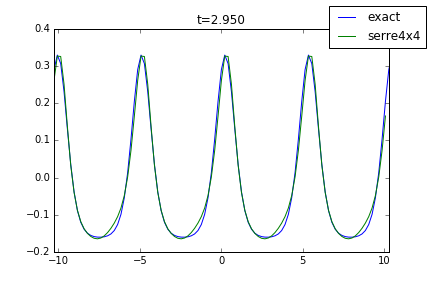
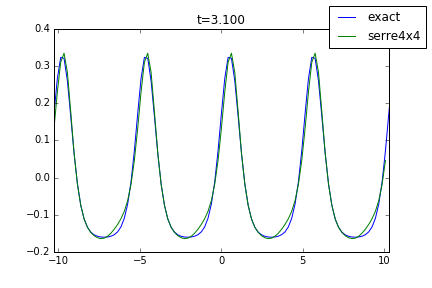
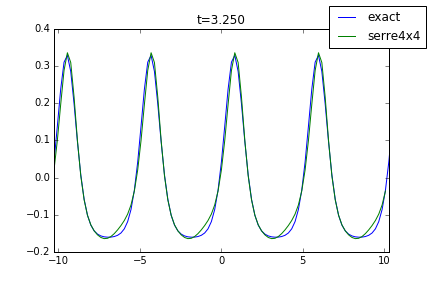
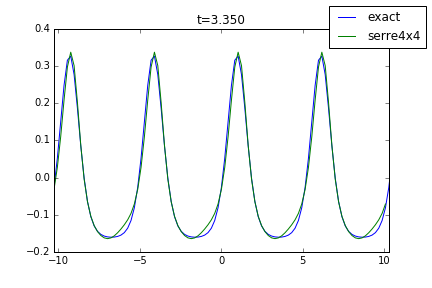
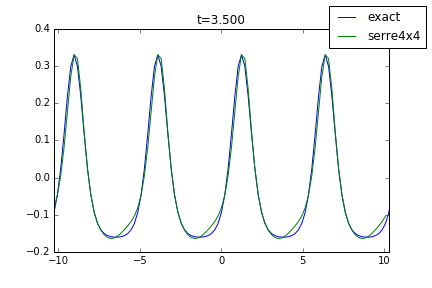
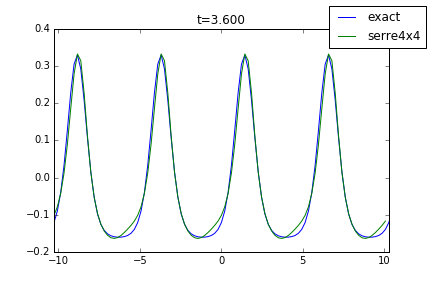
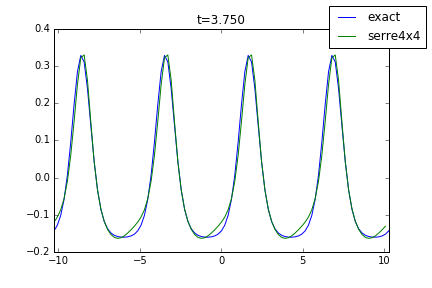
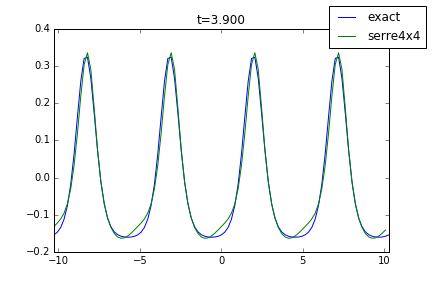
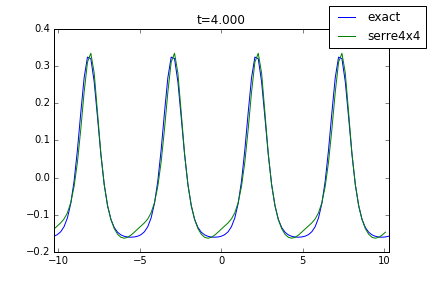
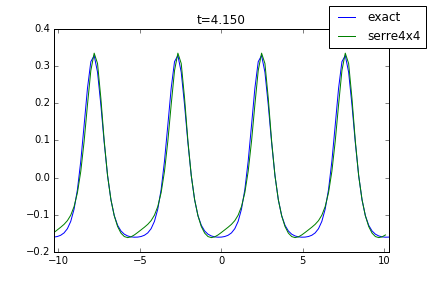
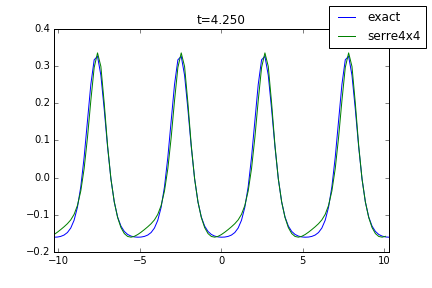
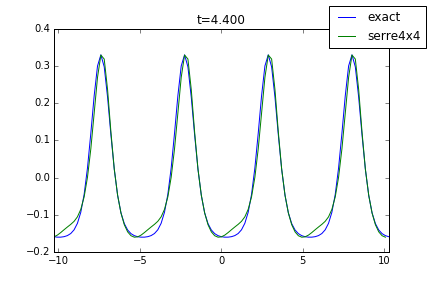
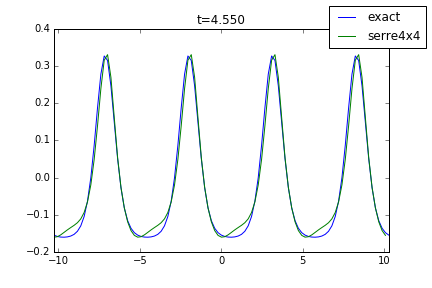
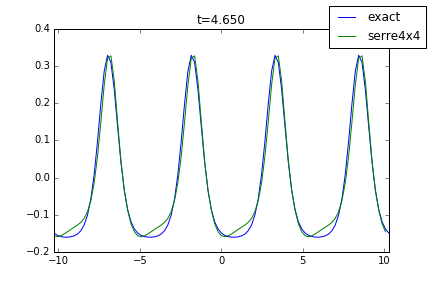
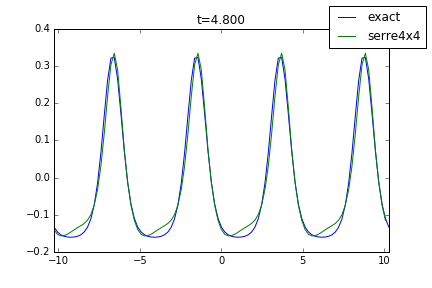
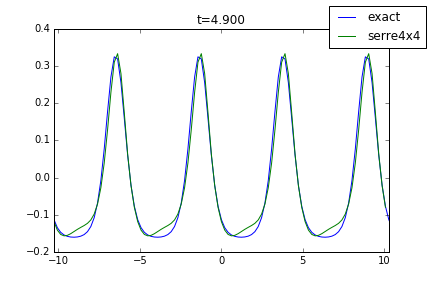
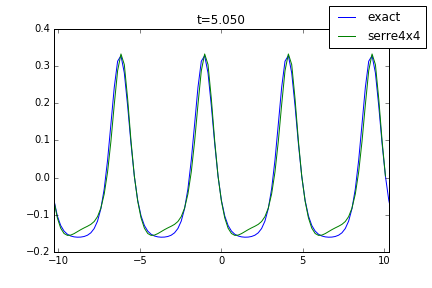

In [14]:
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(-0.2,0.4))

lineExact, = ax.plot(x, uallexact[:,0])
# lineSw, = ax.plot(x[2:-2],hall1[2:-2,0])
# lineSerre2, = ax.plot(x[2:-2],hall2[2:-2,0])
lineSerre4, = ax.plot(x[2:-2],uall3[2:-2,0])


ttl = ax.set_title('t=')
# fig.legend((lineExact,lineSw,lineSerre2,lineSerre4),
#            ('exact','nswe2','serre2x4','serre4x4'))
fig.legend((lineExact,lineSerre4),
           ('exact','serre4x4'))


def animate(i):
    i = min(hall1.shape[0],i*hall1.shape[0]/40)
    ttl.set_text('t=%.3f'%tall1[i])
    
    lineExact.set_data(x, uallexact[:,i])
#     lineSw.set_data(x[2:-2],hall2[2:-2,i])
#     lineSerre2.set_data(x[2:-2],hall1[2:-2,i])    
    lineSerre4.set_data(x[2:-2],uall3[2:-2,i])
    

animation.FuncAnimation(fig, animate, frames=40, interval=200)

It looks very good, except for a small deformation in the bottom after 2 second aprox. For both $h$ and $hu$